# Imports

## Import Lib

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import re
import time

In [5]:
start_time = time.time()

## Import Csv

In [7]:
chunksize = 10 ** 3  # Chunksize de 1000 lignes
filename = 'products.csv'
nan_rates = []

try:
    reader = pd.read_csv(filename, chunksize=chunksize, sep='\t')

    for chunk in reader:
        nan_rates.append(chunk.isna().mean(axis=0))

except pd.errors.ParserError as e:
    print(f"ParserError: {e}")

# Calcul des taux moyens de remplissage des chunks
if nan_rates:
    inds_nan_rate = pd.concat(nan_rates, axis=1).mean(axis=1)
    cols_to_load = inds_nan_rate[inds_nan_rate < 0.7].index.tolist()

    # Chargement des données filtrées
    df = pd.read_csv(filename, sep='\t', usecols=cols_to_load)
    df = df.drop(['url','creator','created_datetime','food_groups_tags','food_groups_en','states_tags','sodium_100g','states_en','last_image_datetime','last_modified_t','last_modified_datetime','created_t','last_modified_by','main_category_en','image_url','image_small_url','last_updated_t','last_image_t','brands_tags','last_updated_datetime','categories_en','categories_tags','countries_tags','countries_en'], axis=1)
    print(df.head())

ParserError: Error tokenizing data. C error: Expected 206 fields in line 1537879, saw 234



/var/folders/25/t6v1433n06x6vfl9wjbxn8sw0000gn/T/ipykernel_3050/3644886759.py:24: DtypeWarning: Columns (0,50,52,56,58,88,89,91,92) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, sep='\t', usecols=cols_to_load)


                     code      product_name   brands  \
0       00000000000000225    jeunes pousses  endives   
1  0000000000000207025004             Andrè      NaN   
2    00000000000003429145           L.casei      NaN   
3    00000000000026772226              Skyr   Danone   
4           0000000000017  Vitória crackers      NaN   

                                          categories  countries  \
0  Aliments et boissons à base de végétaux, Alime...  en:france   
1                                                NaN      en:de   
2                                                NaN      Spain   
3  Produits laitiers, Produits fermentés, Dessert...     France   
4                                                NaN     France   

                                    ingredients_text  \
0                                                NaN   
1                                                NaN   
2  Leche semidesnatada, azucar 6.9%, leche desnat...   
3                                   

# Information de base

In [9]:
df.info

<bound method DataFrame.info of                            code               product_name     brands  \
0             00000000000000225             jeunes pousses    endives   
1        0000000000000207025004                      Andrè        NaN   
2          00000000000003429145                    L.casei        NaN   
3          00000000000026772226                       Skyr     Danone   
4                 0000000000017           Vitória crackers        NaN   
...                         ...                        ...        ...   
3307654              9999999999            Duschgel - Iris        NaN   
3307655             99999999999        Sugo alle Melanzone  La Vialla   
3307656            999999999999       Test Product Product        MTR   
3307657           9999999999994  Light & Free SKYR A BOIRE        NaN   
3307658           9999999999999                 Salatgurke      Edeka   

                                                categories   countries  \
0        Aliments

In [10]:
df.head(5)

,code,product_name,brands,categories,countries,ingredients_text,ingredients_tags,ingredients_analysis_tags,serving_size,serving_quantity,...,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
0,00000000000000225,jeunes pousses,endives,"Aliments et boissons à base de végétaux, Alime...",en:france,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000000207025004,Andrè,NaN,NaN,en:de,NaN,NaN,NaN,NaN,NaN,...,690.0,2.0,2.0,65.0,12.6,3.0,1.5,NaN,NaN,NaN
2,00000000000003429145,L.casei,NaN,NaN,Spain,"Leche semidesnatada, azucar 6.9%, leche desnat...","en:semi-skimmed-milk,en:dairy,en:milk,en:sugar...","en:palm-oil-free,en:non-vegan,en:vegetarian-st...",NaN,NaN,...,NaN,1.4,0.9,9.8,9.8,NaN,2.7,0.10,0.0,NaN
3,00000000000026772226,Skyr,Danone,"Produits laitiers, Produits fermentés, Dessert...",France,NaN,NaN,NaN,NaN,NaN,...,238.0,0.2,0.1,3.9,3.9,NaN,10.0,0.09,NaN,-5.0
4,0000000000017,Vitória crackers,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN,...,1569.0,7.0,3.08,70.1,15.0,NaN,7.8,1.40,NaN,NaN


In [11]:
df.dtypes

code                                                      object
product_name                                              object
brands                                                    object
categories                                                object
countries                                                 object
ingredients_text                                          object
ingredients_tags                                          object
ingredients_analysis_tags                                 object
serving_size                                              object
serving_quantity                                          object
additives_n                                               object
nutriscore_score                                          object
nutriscore_grade                                          object
nova_group                                                object
pnns_groups_1                                             object
pnns_groups_2            

# Nettoyage Données

## Suppression cyrillique

In [14]:
def detect_cyrillic(df, column):
    cyrillic_indices = []
    cyrillic_pattern = re.compile(r'[\u0400-\u04FF]+')  # Unicode Cyrillic characters

    for index, value in df[column].items():
        if isinstance(value, str) and cyrillic_pattern.search(value):
            cyrillic_indices.append(index)

    return cyrillic_indices

cyrillic_indices = detect_cyrillic(df, 'product_name')
df = df.drop(index=cyrillic_indices).reset_index(drop=True)
num_rows_removed = len(cyrillic_indices)
print(f"\nNombre de lignes supprimées : {num_rows_removed}")

print("\nDataFrame après suppression des lignes avec des caractères cyrilliques :")
print(df)


Nombre de lignes supprimées : 20540

DataFrame après suppression des lignes avec des caractères cyrilliques :
                           code               product_name     brands  \
0             00000000000000225             jeunes pousses    endives   
1        0000000000000207025004                      Andrè        NaN   
2          00000000000003429145                    L.casei        NaN   
3          00000000000026772226                       Skyr     Danone   
4                 0000000000017           Vitória crackers        NaN   
...                         ...                        ...        ...   
3287114              9999999999            Duschgel - Iris        NaN   
3287115             99999999999        Sugo alle Melanzone  La Vialla   
3287116            999999999999       Test Product Product        MTR   
3287117           9999999999994  Light & Free SKYR A BOIRE        NaN   
3287118           9999999999999                 Salatgurke      Edeka   

            

## Doublons

In [16]:
for column in df.columns:
    doublons = df[column].duplicated().sum()
    print(f"Column: {column}")
    print(doublons)

Column: code
2838
Column: product_name
1358249
Column: brands
2988547
Column: categories
3078128
Column: countries
3270071
Column: ingredients_text
2466127
Column: ingredients_tags
2567862
Column: ingredients_analysis_tags
3287073
Column: serving_size
3217459
Column: serving_quantity
3283011
Column: additives_n
3287060
Column: nutriscore_score
3287016
Column: nutriscore_grade
3287109
Column: nova_group
3287108
Column: pnns_groups_1
3287104
Column: pnns_groups_2
3287075
Column: food_groups
3287070
Column: states
3280204
Column: ecoscore_grade
3287110
Column: nutrient_levels_tags
3286863
Column: completeness
3287047
Column: main_category
3232260
Column: image_nutrition_url
1489125
Column: image_nutrition_small_url
1489125
Column: energy-kcal_100g
3237302
Column: energy_100g
3276313
Column: fat_100g
3259087
Column: saturated-fat_100g
3267007
Column: carbohydrates_100g
3249310
Column: sugars_100g
3259134
Column: fiber_100g
3274741
Column: proteins_100g
3261497
Column: salt_100g
3249196
Col

### Suppression et verification des doublons dans 'code'

In [18]:
df = df.drop_duplicates(subset='code')
for column in df.columns:
    doublons = df[column].duplicated().sum()
    print(f"Column: {column}")
    print(doublons)

Column: code
0
Column: product_name
1355910
Column: brands
2985778
Column: categories
3075446
Column: countries
3267236
Column: ingredients_text
2463363
Column: ingredients_tags
2565380
Column: ingredients_analysis_tags
3284235
Column: serving_size
3214716
Column: serving_quantity
3280174
Column: additives_n
3284222
Column: nutriscore_score
3284178
Column: nutriscore_grade
3284271
Column: nova_group
3284270
Column: pnns_groups_1
3284266
Column: pnns_groups_2
3284237
Column: food_groups
3284232
Column: states
3277371
Column: ecoscore_grade
3284272
Column: nutrient_levels_tags
3284025
Column: completeness
3284209
Column: main_category
3229429
Column: image_nutrition_url
1486370
Column: image_nutrition_small_url
1486370
Column: energy-kcal_100g
3234488
Column: energy_100g
3273478
Column: fat_100g
3256256
Column: saturated-fat_100g
3264177
Column: carbohydrates_100g
3246487
Column: sugars_100g
3256306
Column: fiber_100g
3271906
Column: proteins_100g
3258666
Column: salt_100g
3246359
Column

In [19]:
df.isna().any()

code                                                     False
product_name                                              True
brands                                                    True
categories                                                True
countries                                                 True
ingredients_text                                          True
ingredients_tags                                          True
ingredients_analysis_tags                                 True
serving_size                                              True
serving_quantity                                          True
additives_n                                               True
nutriscore_score                                          True
nutriscore_grade                                          True
nova_group                                                True
pnns_groups_1                                             True
pnns_groups_2                                          

In [20]:
df.isna().mean()

code                                                     0.000000e+00
product_name                                             5.172274e-02
brands                                                   4.419293e-01
categories                                               5.595864e-01
countries                                                7.355643e-03
ingredients_text                                         7.088873e-01
ingredients_tags                                         7.094579e-01
ingredients_analysis_tags                                6.901267e-01
serving_size                                             7.709179e-01
serving_quantity                                         7.753508e-01
additives_n                                              7.088839e-01
nutriscore_score                                         6.621729e-01
nutriscore_grade                                         6.024759e-03
nova_group                                               7.321261e-01
pnns_groups_1       

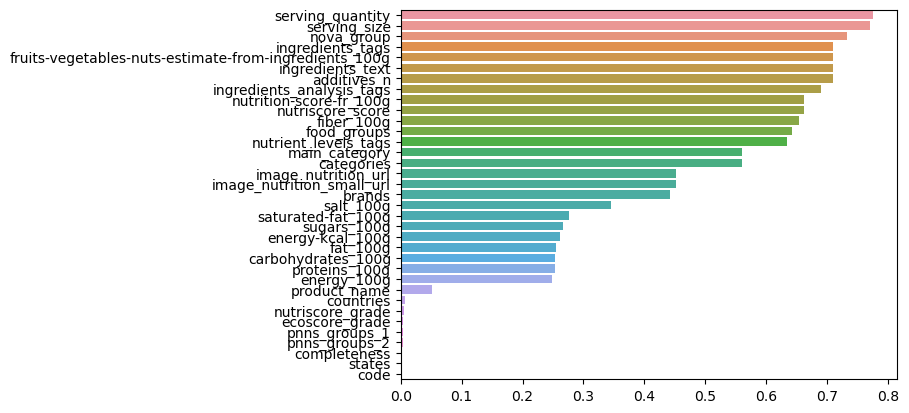

In [21]:
valeurs_manq = df.isna().mean().sort_values(ascending=False)
sns.barplot(x=valeurs_manq.values, y=valeurs_manq.index);

## Detection, modification et suppression des valeurs supérieures a 100 pour 100gr

In [23]:
def count_responses(results_df):
    return results_df.shape[0]

initial_size = df.shape[0]

columns_to_check = [
    'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
    'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g','fruits-vegetables-nuts-estimate-from-ingredients_100g'
]

results = []

for column in columns_to_check:
    # Convertir les valeurs de la colonne en float (si possible)
    df.loc[:, column] = pd.to_numeric(df[column], errors='coerce')
    values_above_100 = df[df[column] > 100][column]
    for idx, value in values_above_100.items():
        results.append((df.loc[idx, 'product_name'], column, value))

results_df = pd.DataFrame(results, columns=['product_name', 'Column', 'Value'])

print("Produits avec des valeurs supérieures à 100 :")
print(results_df)

# Compter le total de réponses
total_responses = count_responses(results_df)
print(f"Total de réponses trouvées : {total_responses}")

Produits avec des valeurs supérieures à 100 :
                     product_name  \
0                        blabblub   
1           Chicken Shawarma Bowl   
2              Asparagus, risotto   
3              Brown Sugar Salmon   
4                             Moz   
...                           ...   
7730  Just Juice orange and apple   
7731               deluxe mix nut   
7732      Grain free keto granola   
7733        Grain free berry Keto   
7734                  goodness me   

                                                 Column   Value  
0                                              fat_100g   222.0  
1                                              fat_100g   350.0  
2                                              fat_100g   610.0  
3                                              fat_100g  3400.0  
4                                              fat_100g   261.0  
...                                                 ...     ...  
7730  fruits-vegetables-nuts-estimate-from-ingr

### Affichage valeur unique product_name

In [25]:
unique_product_counts = df['product_name'].value_counts()
print("Valeurs uniques dans la colonne 'product_name' et leur nombre :")
print(unique_product_counts)

Valeurs uniques dans la colonne 'product_name' et leur nombre :
product_name
Miel                                             1827
Aceite de oliva virgen extra                     1632
Filet de poulet                                  1445
Spaghetti                                        1303
Chocolat                                         1253
                                                 ... 
Actimel mind guarana                                1
Actimel activate                                    1
Le petit Frais                                      1
Le petit frais gervais nature 3,9 % 60 g x 12       1
Light & Free SKYR A BOIRE                           1
Name: count, Length: 1928370, dtype: int64


## Remplacement des >100 par la moyenne en fonction de product name

In [27]:
columns_to_check = [
    'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
    'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g','fruits-vegetables-nuts-estimate-from-ingredients_100g'
]

# Convertir les valeurs des colonnes en float
df[columns_to_check] = df[columns_to_check].apply(pd.to_numeric, errors='coerce')

# Calculer les moyennes des colonnes en fonction de 'product_name'
means = df.groupby('product_name')[columns_to_check].transform('mean')

# Remplacer les valeurs supérieures à 100 par la moyenne correspondante
for column in columns_to_check:
    df[column] = np.where(df[column] > 100, means[column], df[column])

# Vérifier les valeurs supérieures à 100 après correction
values_above_100 = df[columns_to_check] > 100
count_above_100 = values_above_100.sum().sum()
print(f"Nombre de valeurs supérieures à 100 après correction : {count_above_100}")

# Supprimer les lignes contenant des valeurs supérieures à 100
df.drop(index=df[values_above_100.any(axis=1)].index, inplace=True)
print("DataFrame après suppression des valeurs supérieures à 100 :")
print(df)

Nombre de valeurs supérieures à 100 après correction : 6098
DataFrame après suppression des valeurs supérieures à 100 :
                           code               product_name     brands  \
0             00000000000000225             jeunes pousses    endives   
1        0000000000000207025004                      Andrè        NaN   
2          00000000000003429145                    L.casei        NaN   
3          00000000000026772226                       Skyr     Danone   
4                 0000000000017           Vitória crackers        NaN   
...                         ...                        ...        ...   
3287114              9999999999            Duschgel - Iris        NaN   
3287115             99999999999        Sugo alle Melanzone  La Vialla   
3287116            999999999999       Test Product Product        MTR   
3287117           9999999999994  Light & Free SKYR A BOIRE        NaN   
3287118           9999999999999                 Salatgurke      Edeka   

   

## Iterative imputer dans les valeurs NaN 

In [29]:
df[columns_to_check] = df[columns_to_check].apply(pd.to_numeric, errors='coerce')

modified_count = 0

# Utiliser IterativeImputer pour remplacer les NaN
imputer = IterativeImputer(random_state=0)
df_imputed = imputer.fit_transform(df[columns_to_check])

# Compter les valeurs modifiées
for col in columns_to_check:
    modified_count += df[col].isna().sum() - np.isnan(df_imputed[:, columns_to_check.index(col)]).sum()

# Remplacer les valeurs NaN dans le DataFrame d'origine
df[columns_to_check] = df_imputed

# Afficher le DataFrame final après imputation
print("DataFrame après imputation itérative :")
print(df)

# Afficher le nombre de valeurs modifiées
print(f"Nombre de valeurs modifiées : {modified_count}")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


DataFrame après imputation itérative :
                           code               product_name     brands  \
0             00000000000000225             jeunes pousses    endives   
1        0000000000000207025004                      Andrè        NaN   
2          00000000000003429145                    L.casei        NaN   
3          00000000000026772226                       Skyr     Danone   
4                 0000000000017           Vitória crackers        NaN   
...                         ...                        ...        ...   
3287114              9999999999            Duschgel - Iris        NaN   
3287115             99999999999        Sugo alle Melanzone  La Vialla   
3287116            999999999999       Test Product Product        MTR   
3287117           9999999999994  Light & Free SKYR A BOIRE        NaN   
3287118           9999999999999                 Salatgurke      Edeka   

                                                categories   countries  \
0        A

## Suppression des NaN dans product_name

In [32]:
nombre_lignes_avant = df.shape[0]
df.dropna(subset=['product_name'], inplace=True)
nombre_lignes_apres = df.shape[0]
nombre_lignes_supprimees = nombre_lignes_avant - nombre_lignes_apres
print(f"\nNombre de lignes supprimées: {nombre_lignes_supprimees}")


Nombre de lignes supprimées: 169872


### Pourcentage des 0 et NaN restant

In [34]:
zero_percentages = (df == 0).sum() / df.shape[0] * 100
nan_percentages = df.isna().sum() / df.shape[0] * 100
print("Pourcentage des valeurs égales à 0 :")
print(zero_percentages)
print("\nPourcentage des NaN :")
print(nan_percentages)

Pourcentage des valeurs égales à 0 :
code                                                      0.000000
product_name                                              0.000000
brands                                                    0.000000
categories                                                0.000000
countries                                                 0.000000
ingredients_text                                          0.000000
ingredients_tags                                          0.000000
ingredients_analysis_tags                                 0.000000
serving_size                                              0.000000
serving_quantity                                          0.136452
additives_n                                              12.883559
nutriscore_score                                          2.085110
nutriscore_grade                                          0.000000
nova_group                                                0.000000
pnns_groups_1            

In [35]:
df.head(5)

,code,product_name,brands,categories,countries,ingredients_text,ingredients_tags,ingredients_analysis_tags,serving_size,serving_quantity,...,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
0,00000000000000225,jeunes pousses,endives,"Aliments et boissons à base de végétaux, Alime...",en:france,NaN,NaN,NaN,NaN,NaN,...,NaN,13.542942,4.969109,27.898991,12.605099,2.960808,9.159905,1.370723,18.147514,NaN
1,0000000000000207025004,Andrè,NaN,NaN,en:de,NaN,NaN,NaN,NaN,NaN,...,690.0,2.000000,2.000000,65.000000,12.600000,3.000000,1.500000,1.250139,4.342127,NaN
2,00000000000003429145,L.casei,NaN,NaN,Spain,"Leche semidesnatada, azucar 6.9%, leche desnat...","en:semi-skimmed-milk,en:dairy,en:milk,en:sugar...","en:palm-oil-free,en:non-vegan,en:vegetarian-st...",NaN,NaN,...,NaN,1.400000,0.900000,9.800000,9.800000,-2.671061,2.700000,0.100000,0.000000,NaN
3,00000000000026772226,Skyr,Danone,"Produits laitiers, Produits fermentés, Dessert...",France,NaN,NaN,NaN,NaN,NaN,...,238.0,0.200000,0.100000,3.900000,3.900000,1.366521,10.000000,0.090000,24.030726,-5.0
4,0000000000017,Vitória crackers,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN,...,1569.0,7.000000,3.080000,70.100000,15.000000,5.444861,7.800000,1.400000,4.662744,NaN


## Modifications valeurs negatives

In [37]:
columns_to_check = [
    'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
    'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g'
]

# Vérifier, compter et afficher les valeurs négatives
negative_values = {}

for column in columns_to_check:
    negative_rows = df[df[column] < 0]
    count_negatives = negative_rows.shape[0]
    if count_negatives > 0:
        negative_values[column] = count_negatives
        print(f"Colonne '{column}':")
        print(negative_rows[['product_name', column]])
        print(f"Nombre de valeurs négatives dans '{column}': {count_negatives}")
        print()

# Convertir les valeurs négatives en valeurs positives dans le DataFrame principal
df[columns_to_check] = df[columns_to_check].abs()

# Afficher le résumé des valeurs négatives
print("\nRésumé des valeurs négatives converties :")
for column, count in negative_values.items():
    print(f"Colonne '{column}': {count} valeurs négatives converties en positives")

Colonne 'fat_100g':
                                              product_name  fat_100g
630                                         Mini Confettis -0.730535
103264   Fruity Whirls, Naturally Flavored Sweetened Ce... -0.502065
193805              Instant Pudding & Pie Filling, Caramel -4.018673
208599               Rips, Licorice Giant Belt, Strawberry -0.593387
232451       Rocky Mountain Ghostbusters Marshmallows 250G -0.364162
...                                                    ...       ...
3204486                    Boisson énergisante regular Red -0.290693
3230036                                    Peaches & Cream -4.715013
3249526                           Coffee & Chicory Essence -1.279820
3265440                                        Icing sugar -6.597431
3276691                                         Palmzucker -1.461232

[186 rows x 2 columns]
Nombre de valeurs négatives dans 'fat_100g': 186

Colonne 'saturated-fat_100g':
                                              pr

In [38]:
df.head(5)

,code,product_name,brands,categories,countries,ingredients_text,ingredients_tags,ingredients_analysis_tags,serving_size,serving_quantity,...,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
0,00000000000000225,jeunes pousses,endives,"Aliments et boissons à base de végétaux, Alime...",en:france,NaN,NaN,NaN,NaN,NaN,...,NaN,13.542942,4.969109,27.898991,12.605099,2.960808,9.159905,1.370723,18.147514,NaN
1,0000000000000207025004,Andrè,NaN,NaN,en:de,NaN,NaN,NaN,NaN,NaN,...,690.0,2.000000,2.000000,65.000000,12.600000,3.000000,1.500000,1.250139,4.342127,NaN
2,00000000000003429145,L.casei,NaN,NaN,Spain,"Leche semidesnatada, azucar 6.9%, leche desnat...","en:semi-skimmed-milk,en:dairy,en:milk,en:sugar...","en:palm-oil-free,en:non-vegan,en:vegetarian-st...",NaN,NaN,...,NaN,1.400000,0.900000,9.800000,9.800000,2.671061,2.700000,0.100000,0.000000,NaN
3,00000000000026772226,Skyr,Danone,"Produits laitiers, Produits fermentés, Dessert...",France,NaN,NaN,NaN,NaN,NaN,...,238.0,0.200000,0.100000,3.900000,3.900000,1.366521,10.000000,0.090000,24.030726,-5.0
4,0000000000017,Vitória crackers,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN,...,1569.0,7.000000,3.080000,70.100000,15.000000,5.444861,7.800000,1.400000,4.662744,NaN


# Timer

In [40]:
end_time = time.time()
execution_time = end_time - start_time

print(f"Temps d'exécution total du notebook : {execution_time:.4f} secondes")

Temps d'exécution total du notebook : 317.6903 secondes
